# Dummy Classifier

A lot of the code is from here: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

## CONFIG

In [1]:
MODEL_NAME = 'dummy-classifier'

# Imports

In [2]:
import os
import copy

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision
from torchvision.io import read_image
from torchvision import datasets, models, transforms

from tqdm.notebook import trange, tqdm

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
%cd ../utils/

from config import CATEGORIES_OF_INTEREST
from config import IMG_SIZE, NORMALIZATION_MEAN, NORMALIZATION_STD

from my_transforms import baseline_train_transforms, SimCLR_train_transforms, dev_transforms

from my_dataloaders import CocoNoCropping

%cd ../notebooks/

/Users/gbatch/Google Drive/colab_projects/cocoapi/utils
/Users/gbatch/Google Drive/colab_projects/cocoapi/notebooks


# Transforms, Datasets, and Data Loaders

In [5]:
train1_dataset = CocoNoCropping(
    img_ids = '../my_splits/train1_ids.txt',
    my_annotations_file = '../my_annotations/imgIds_to_labels_train2017.json',
    img_dir = '../my_images/train1/',
    transform=baseline_train_transforms,
    divide_by_255=True
)

dev1_dataset = CocoNoCropping(
    img_ids = '../my_splits/dev1_ids.txt',
    my_annotations_file = '../my_annotations/imgIds_to_labels_train2017.json',
    img_dir = '../my_images/dev1/',
    transform=dev_transforms,
    divide_by_255=True
)

In [6]:
# droplast since the number of images is likely not to be divisible by batch_size
train1_dataloader = DataLoader(train1_dataset, batch_size=32, shuffle=True)
dev1_dataloader = DataLoader(dev1_dataset, batch_size=32, shuffle=False)

# Visualize a few images

(906, 1810, 3)


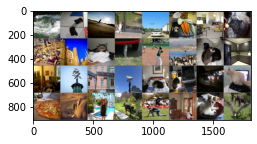

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
bird,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
cat,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,0,0,1,0
dog,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
person,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,1,1,1,0,0,0


In [7]:
fig, ax = plt.subplots(figsize=(18, 2))
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    print(inp.shape)
    
    # ImageNet constants
    mean = np.array(NORMALIZATION_MEAN)
    std = np.array(NORMALIZATION_STD)
    
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
batch = next(iter(train1_dataloader))
inputs, labels = batch['image'], batch['label']

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

pd.DataFrame({CATEGORIES_OF_INTEREST[i]: labels[i].numpy() for i in range(len(labels))}).T

In [8]:
labels = torch.vstack(batch['label']).T.contiguous().to(torch.float32).to(device)
labels

tensor([[0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 1., 1., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 1., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 1., 1., 0.],
        [0., 0., 0., 0.],
        [0., 1., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 1., 1.],
        [0., 1., 0., 1.],
        [0., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 0., 0., 1.],
        [0., 0., 1., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.]])

In [9]:
labels.sum()

tensor(30.)

# Training and Validation Loops

In [10]:
def evaluate_dummy(iterator, criterion):
    total = 0
    total_present = 0
    
    epoch_loss = 0
    per_class_correct = torch.zeros(4)
    
    for batch in tqdm(iterator):
        
        # no need for gradients, batch-norm and dropout in evaluation mode
        with torch.no_grad():
            
            inputs = batch['image'].to(device) # [batch size, channel, h, w]
            #print(inputs.shape, inputs.dtype)
            # right now, `labels` is a list with num_classes tensors, each tensor with batch_size of labels (integers)
            labels = torch.vstack(batch['label']).T.contiguous().to(torch.float32).to(device)
            #print(labels.shape, labels.dtype, labels.is_contiguous()) # labels
            total += labels.shape[0]
            total_present += labels.sum()
             
            all_zeros = torch.zeros_like(labels).to(device)
            all_one_half = all_zeros + 0.5
            #print(labels.sum(), outputs.sum())
            #print(outputs.shape, outputs.dtype, outputs.is_contiguous())
            #print(outputs)

            loss = criterion(all_one_half, labels)
            #print(loss)
            epoch_loss += loss.item() # no need to drag the gradient
            #print(loss.item())

            preds = (all_zeros > 0.5).detach().to(torch.int32) # no need to drag the gradients
            #print(preds)
            per_class_correct += (preds.cpu() == labels.cpu()).sum(0) # 0-th axis for batch_size
            #print(per_class_correct)
    
    avg_epoch_loss = epoch_loss / total
    avg_per_class_acc = per_class_correct / total
    
    return avg_epoch_loss, avg_per_class_acc, total_present, total

In [11]:
criterion = torch.nn.BCELoss(reduction='sum')

train_avg_epoch_loss, train_avg_per_class_acc, train_total_present, train_total = evaluate_dummy(train1_dataloader, criterion)
print(train_avg_epoch_loss)
print(train_avg_per_class_acc)
print(train_avg_per_class_acc.mean())
print(train_total_present, train_total)

dev_avg_epoch_loss, dev_avg_per_class_acc, dev_total_present, dev_total = evaluate_dummy(dev1_dataloader, criterion)
print(dev_avg_epoch_loss)
print(dev_avg_per_class_acc)
print(dev_avg_per_class_acc.mean())
print(dev_total_present, dev_total)

  0%|          | 0/20 [00:00<?, ?it/s]

2.772588726816375
tensor([0.7974, 0.7927, 0.7767, 0.6348])
tensor(0.7504)
tensor(626.) 627


  0%|          | 0/20 [00:00<?, ?it/s]

2.772588726835659
tensor([0.7876, 0.7924, 0.7797, 0.6323])
tensor(0.7480)
tensor(636.) 631


### Save history

In [12]:
%mkdir ../history

mkdir: ../history: File exists


In [13]:
history = {
    'loss_w_all_one_half_probs': train_avg_epoch_loss,
    
    'train_per_class_accuracies': list(train_avg_per_class_acc.numpy().astype(float)),
    'dev_per_class_accuracies': list(dev_avg_per_class_acc.numpy().astype(float)),

    'train_average_accuracy': float(train_avg_per_class_acc.mean().item()),
    'dev_average_accuracy': float(dev_avg_per_class_acc.mean().item()),
}
                                  
history

{'loss_w_all_one_half_probs': 2.772588726816375,
 'train_per_class_accuracies': [0.7974481582641602,
  0.7926634550094604,
  0.7767145037651062,
  0.6347687244415283],
 'dev_per_class_accuracies': [0.7876386642456055,
  0.7923930287361145,
  0.7797147631645203,
  0.6323296427726746],
 'train_average_accuracy': 0.7503986954689026,
 'dev_average_accuracy': 0.7480190396308899}

In [14]:
with open(f'../history/{MODEL_NAME}.json', 'w') as f:
    json.dump(history, f)

In [15]:
%ls ../history

2-layer-head-baseline-2021-06-16.json
2-layer-head_dropout=0.5_2021-06-16.json
2-layer-head_dropout=0.5_wd=0.2_2021-06-16.json
2-layer-head_dropout=0.5_wd=1_2021-06-16.json
2-layer-head_dropout=0.8_2021-06-16.json
2-layer-head_dropout=0.8_wd=0.1_2021-06-16.json
2-layer-head_dropout=0.8_wd=1_2021-06-16.json
Adam_wd=0.0001_2021-06-11.json
Adam_wd=0.01_2021-06-11.json
Adam_wd=100_2021-06-11.json
Adam_wd=10_2021-06-11.json
Adam_wd=1_2021-06-11.json
Adam_wd=1e-08_2021-06-11.json
baseline-2021-06-08.json
baseline-2021-06-09.json
baseline-Adam-2021-06-11.json
dummy-classifier.json
efficientnet-b2_1-layer-head-finetuned.json
efficientnet-b2_baseline_2021-06-17.json
efficientnet-b3_1-layer-head-finetuned.json
efficientnet-b3_2-layer-head-finetuned.json
efficientnet-b3_2-layer-head_p=0.8_2021-06-17.json
efficientnet-b3_baseline_2021-06-17.json
gated-attention_dilated-block=False_resnet18_2021-06-30.json
gated-attention_dilated-block=False_resnet18_wd=10_2021-06-30.json
gated-attention_dilated-bl